<h1>Assign 1 - Deep Learning</h1>
Jonathan Menahem - 203772611 <br>
Alon Mazri - 

Help Source: [https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/](https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/)

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h1>Exploring The Data</h1>

In [3]:
# Identify Image Resolutions

# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
root_path = 'chest_xray\\train\\NORMAL\\'
imgs = [img.name for img in Path(root_path).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root_path+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 1341


,FileName,Size,Width,Height,Aspect Ratio
0,IM-0115-0001.jpeg,"(2090, 1858)",2090,1858,1.12
1,IM-0117-0001.jpeg,"(1422, 1152)",1422,1152,1.23
2,IM-0119-0001.jpeg,"(1810, 1434)",1810,1434,1.26
3,IM-0122-0001.jpeg,"(1618, 1279)",1618,1279,1.27
4,IM-0125-0001.jpeg,"(1600, 1125)",1600,1125,1.42


Text(0, 0.5, 'Height')

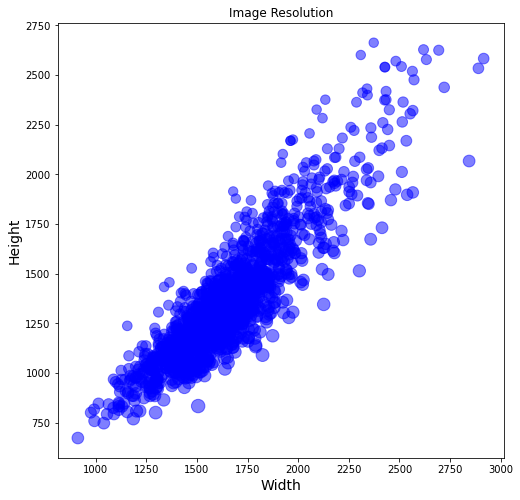

In [4]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

<h2>Loading The Data</h2>

In [5]:
# importing the data into variables

def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))

    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(400,400))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(400,400))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels 

In [6]:
norm_images, norm_labels = load_normal("chest_xray\\train\\NORMAL\\")
pneu_images, pneu_labels = load_pneumonia("chest_xray\\train\\PNEUMONIA\\")

100%|██████████| 3875/3875 [00:21<00:00, 178.39it/s]


In [7]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [8]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

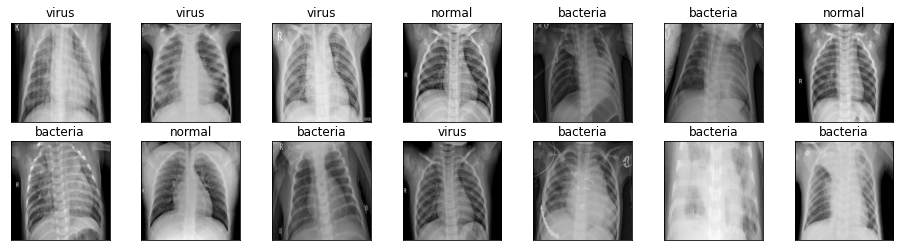

In [9]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [10]:
norm_images_val, norm_labels_val = load_normal("chest_xray\\val\\NORMAL\\")
pneu_images_val, pneu_labels_val = load_pneumonia("chest_xray\\val\\PNEUMONIA\\")
X_val = np.append(norm_images_val, pneu_images_val, axis=0)
y_val = np.append(norm_labels_val, pneu_labels_val)

100%|██████████| 8/8 [00:00<00:00, 182.31it/s]


In [11]:
norm_images_test, norm_labels_test = load_normal("chest_xray\\test\\NORMAL\\")
pneu_images_test, pneu_labels_test = load_pneumonia("chest_xray\\test\\PNEUMONIA\\")
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:01<00:00, 198.44it/s]


In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [13]:
#testing the new shape of our data:

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5216, 400, 400, 1)
(16, 400, 400, 1)
(624, 400, 400, 1)


<h2>Building The Model</h2>

In [14]:
print(y_train)

['normal' 'normal' 'normal' ... 'bacteria' 'bacteria' 'bacteria']


In [15]:
from sklearn.preprocessing import LabelEncoder

num_classes = 3
input_shape = (400, 400, 1)

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (200, 200, 1)
print(X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

le = LabelEncoder()
le.fit(y_train)
y_train_le = le.transform(y_train)
le.fit(y_test)
y_test_le = le.transform(y_test)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_le, num_classes)
y_test = keras.utils.to_categorical(y_test_le, num_classes)

(5216, 400, 400, 1)
5216 train samples
624 test samples


# Basic Model (without convolution layers)

In [16]:
basic_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(10, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)  # No weights at this stage!

TypeError: __init__() got an unexpected keyword argument 'basic_model'

In [17]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400, 400, 10)      20        
                                                                 
 dense_1 (Dense)             (None, 400, 400, 6)       66        
                                                                 
 dense_2 (Dense)             (None, 400, 400, 2)       14        
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dropout (Dropout)           (None, 320000)            0         
                                                                 
 dense_3 (Dense)             (None, 3)                 960003    
                                                                 
Total params: 960,103
Trainable params: 960,103
Non-trai

In [24]:
batch_size = 128
epochs = 20

basic_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

basic_history = basic_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.15)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [19]:
# list all data in history
print(basic_history.history.keys())
# summarize history for accuracy
plt.plot(basic_history.history['accuracy'])
plt.plot(basic_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(basic_history.history['loss'])
plt.plot(basic_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'basic_history' is not defined

# Advanced Model (using convolution layers)

In [32]:
advanced_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)  # No weights at this stage!

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [22]:
advanced_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 394, 394, 32)      1600      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 141376)            0         
                                                                 
 dropout_1 (Dropout)         (None, 141376)           

In [23]:
batch_size = 128
epochs = 25

advanced_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

advanced_history = advanced_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/60


KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


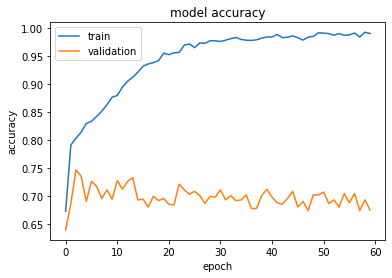

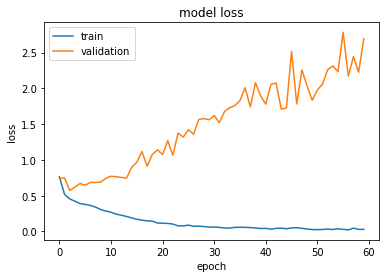

In [19]:
# list all data in history
print(advanced_history.history.keys())
# summarize history for accuracy
plt.plot(advanced_history.history['accuracy'])
plt.plot(advanced_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(advanced_history.history['loss'])
plt.plot(advanced_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()